In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = '/content/gdrive/MyDrive/Data'

Mounted at /content/gdrive


In [2]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep

In [3]:
experience = 1

number_columns = 5
#number_columns = 3
#number_columns = 2

def construct_training_labels(number_columns, labels):
  n = labels.shape[0]
  training_labels = np.zeros((n,number_columns))
  for i in range(n):
    training_labels[i][labels[i]] = 1
  return training_labels

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_wake(val):
  arr = {'N1':0, 'N2':0, 'N3':0, 'REM':0, 'Wake':1, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_pos(val):
  arr = {'Supine;':0, 'Upright;':1, 'Right;':2, 'Prone;':3, 'Left;':4, 'Artefact;':np.NaN, 'A;':np.NaN}
  return arr[val]

def encode_sleep_hr(val):
  if val == 'A;':
    return np.NaN
  n = len(val)
  val = int(val[:n-1])
  if (val < 60):
    return 0
  if (val < 100 and val >= 60):
    return 1
  return 2

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

file_name = os.path.join(features_dir, "RawUnlabelled")
#file_name = os.path.join(features_dir, "UnlabelledHR")
#file_name = os.path.join(features_dir, "UnlabelledPOS")

unlabelled_dataset = pd.read_pickle(file_name)

file_name_stage = os.path.join(features_dir, "RawLabelled")
file_name_hr = os.path.join(features_dir, "RawLabelledHR")
file_name_pos = os.path.join(features_dir, "RawLabelledPOS")

labelled_dataset_stage = pd.read_pickle(file_name_stage)
labelled_dataset_wake = pd.read_pickle(file_name_stage)
labelled_dataset_hr = pd.read_pickle(file_name_hr)
labelled_dataset_pos = pd.read_pickle(file_name_pos)

OnLabel = ["Label", 'X1', 'X2', 'Y1', 'Y2', 'Z1', 'Z2', 'Temp','Activity', 'Sleep State']

print(labelled_dataset_pos.head(1))

new_labelled_dataset = pd.merge(labelled_dataset_stage, labelled_dataset_pos, on=OnLabel)
merged_test_dataset = pd.merge(new_labelled_dataset, labelled_dataset_hr, on=OnLabel)
merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep State']

#print(new_labelled_dataset)

labels_stage = merged_test_dataset['Sleep State']
labels_wake = merged_test_dataset['Sleep Wake']
labels_pos = merged_test_dataset['Value_x']
labels_hr = merged_test_dataset['Value_y']

#print(labels_stage.unique())
#print(labels_wake.unique())
#print(labels_pos.unique())
#print(labels_hr.unique())
#print(unlabelled_dataset.shape)

save_sleep_labels_sleep_stage = os.path.join(features_dir, "RawSleepStageLabels.npy")
save_sleep_labels_sleep_wake = os.path.join(features_dir, "RawSleepWakeLabels.npy")
save_sleep_labels_sleep_pos = os.path.join(features_dir, "RawSleepPosLabels.npy")
save_sleep_labels_sleep_hr = os.path.join(features_dir, "RawSleepHRLabels.npy")

y_labels_stage = np.load(save_sleep_labels_sleep_stage)
y_labels_wake = np.load(save_sleep_labels_sleep_wake)
y_labels_pos = np.load(save_sleep_labels_sleep_pos)
y_labels_hr = np.load(save_sleep_labels_sleep_hr)

print(np.unique(y_labels_stage))


merged_test_dataset['Sleep State'] = merged_test_dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
merged_test_dataset['Sleep State'] = pd.Series(np.array(merged_test_dataset['Sleep State'])).interpolate()
merged_test_dataset['Sleep State'] = np.array(merged_test_dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Sleep Wake'] = merged_test_dataset['Sleep Wake'].apply(lambda x: encode_sleep_wake(x))
merged_test_dataset['Sleep Wake'] = pd.Series(np.array(merged_test_dataset['Sleep Wake'])).interpolate()
merged_test_dataset['Sleep Wake'] = np.array(merged_test_dataset['Sleep Wake'].replace(to_replace = np.nan, value=4), dtype=np.int64)

merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: encode_sleep_pos(x))
#print(dataset['Value'].unique())
merged_test_dataset['Value_x'] = pd.Series(np.array(merged_test_dataset['Value_x'])).interpolate()
merged_test_dataset['Value_x'] = merged_test_dataset['Value_x'].apply(lambda x: int(x))

merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: encode_sleep_hr(x))
merged_test_dataset['Value_y'] = pd.Series(np.array(merged_test_dataset['Value_y'])).interpolate()
merged_test_dataset['Value_y'] = merged_test_dataset['Value_y'].apply(lambda x: int(x))

y_labels_stage_values = np.array(merged_test_dataset['Sleep State'])
y_labels_wake_values = np.array(merged_test_dataset['Sleep Wake'])
y_labels_pos_values = np.array(merged_test_dataset['Value_x'])
y_labels_hr_values = np.array(merged_test_dataset['Value_y'])

y_test_stage = construct_training_labels(5, y_labels_stage_values)
y_test_wake = construct_training_labels(2, y_labels_wake_values)
y_test_pos = construct_training_labels(5, y_labels_pos_values)
y_test_hr = construct_training_labels(3, y_labels_hr_values)

y_train_stage = construct_training_labels(5, y_labels_stage)
y_train_wake = construct_training_labels(2, y_labels_wake)
y_train_pos = construct_training_labels(5, y_labels_pos)
y_train_hr = construct_training_labels(3, y_labels_hr)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

#scale_columns = ['X1','X2','Y1','Y2','Z1','Z2']
#scaler = scaler.fit(merged_test_dataset[scale_columns])

#merged_test_dataset.loc[:, scale_columns] = scaler.transform(
#  merged_test_dataset[scale_columns].to_numpy()
#)

#unlabelled_dataset.loc[:, scale_columns] = scaler.transform(
#  unlabelled_dataset[scale_columns].to_numpy()
#)

def split_trains_sets(train_set, split_ratio):
  n = train_set.shape[0]
  split_point = int(split_ratio * n)
  split_train_1 = train_set[:split_point]
  split_train_2 = train_set[split_point:]
  return split_train_1, split_train_2

train_split_ratio = 0.75

#print(y_train_wake.shape)
#unlabelled_dataset['Sleep Wake'] = y_labels_wake
#unlabelled_dataset['Sleep Pos'] = y_labels_pos
#unlabelled_dataset['Sleep Hr'] = y_labels_hr
#unlabelled_dataset = unlabelled_dataset.sample(frac=1).reset_index(drop=True)

x_test = np.array(merged_test_dataset.drop(['Label','Sleep State', 'Sleep Wake', 'Value_x', 'Value_y'], axis=1))
#x_train = np.array(unlabelled_dataset.drop(['Label','Sleep State', 'Sleep Wake', 'Sleep Pos', 'Sleep Hr'], axis=1))
x_train = np.array(unlabelled_dataset.drop(['Label','Sleep State'], axis=1))

y_train_stage, additional_stage = split_trains_sets(y_train_stage, train_split_ratio)
y_train_wake, additional_wake = split_trains_sets(y_train_wake, train_split_ratio)
y_train_pos, additional_pos = split_trains_sets(y_train_pos, train_split_ratio)
y_train_hr, additional_hr = split_trains_sets(y_train_hr, train_split_ratio)

x_train, additional_train = split_trains_sets(x_train, train_split_ratio)

y_test_stage = np.append(y_test_stage, additional_stage, axis=0)
y_test_wake = np.append(y_test_wake, additional_wake, axis=0)
y_test_pos = np.append(y_test_pos, additional_pos, axis=0)
y_test_hr = np.append(y_test_hr, additional_hr, axis=0)

x_test = np.append(x_test, additional_train, axis=0)


#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1, 1))
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1, 1))

print(x_test.shape)
print(x_train.shape)

print(y_test_stage)

                 Label        X1        X2        Y1        Y2        Z1  \
0  2020-02-12 22:15:30 -0.521875 -0.522604 -0.078323 -0.085365  0.813146   

        Z2   Temp  Activity    Value Sleep State  
0  0.81325  266.0      51.0  Supine;        Wake  
[0 1 2 3 4]
(141363, 8)
(372128, 8)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


In [ ]:
#print(merged_test_dataset['Activity'].unique())

False
False


Multi-task

Epoch 1/2
11629/11629 [==============================] - 49s 4ms/step - loss: 1.8657 - sleep_stage_dense_2_loss: 0.4045 - sleep_wake_dense_2_loss: 0.3474 - sleep_pos_dense_2_loss: 0.7661 - sleep_hr_dense_2_loss: 0.3477 - sleep_stage_dense_2_accuracy: 0.8825 - sleep_wake_dense_2_accuracy: 0.8275 - sleep_pos_dense_2_accuracy: 0.7262 - sleep_hr_dense_2_accuracy: 0.8608 - val_loss: 1.9920 - val_sleep_stage_dense_2_loss: 0.6051 - val_sleep_wake_dense_2_loss: 0.3590 - val_sleep_pos_dense_2_loss: 0.6320 - val_sleep_hr_dense_2_loss: 0.3958 - val_sleep_stage_dense_2_accuracy: 0.8158 - val_sleep_wake_dense_2_accuracy: 0.8187 - val_sleep_pos_dense_2_accuracy: 0.7824 - val_sleep_hr_dense_2_accuracy: 0.8431
Epoch 2/2
11629/11629 [==============================] - 54s 5ms/step - loss: 1.5418 - sleep_stage_dense_2_loss: 0.3745 - sleep_wake_dense_2_loss: 0.3016 - sleep_pos_dense_2_loss: 0.5497 - sleep_hr_dense_2_loss: 0.3160 - sleep_stage_dense_2_accuracy: 0.8829 - sleep_wake_dense_2_accuracy: 0.8554 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


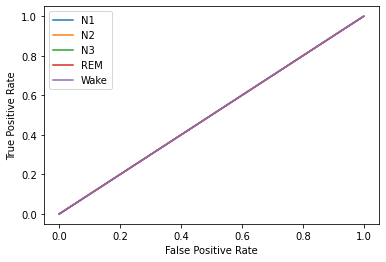

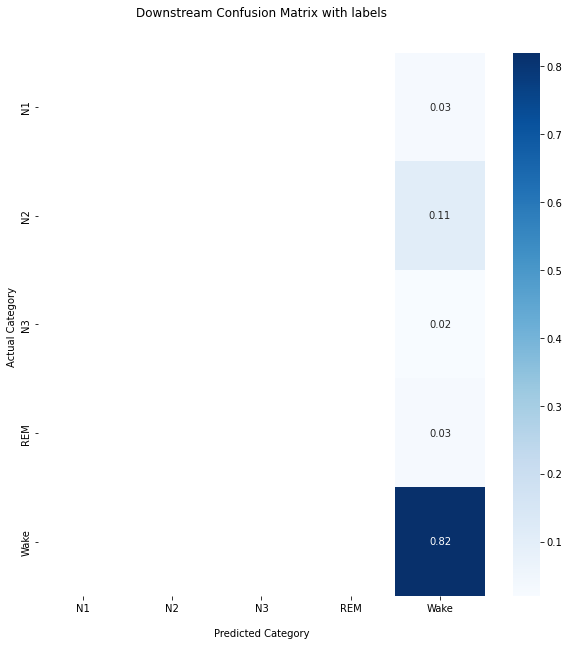

[[26983  9600]
 [12824 91956]]
Precision, Recall and F1 Score for Sleep are 0.68, 0.74, 0.71
Precision, Recall and F1 Score for Wake are 0.91, 0.88, 0.89
(2, 2)
Accuracy is 0.8
Performance is 0.8


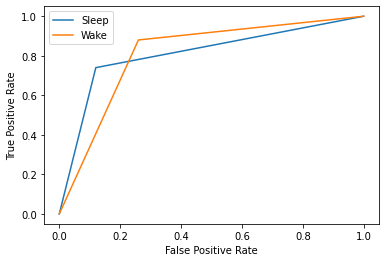

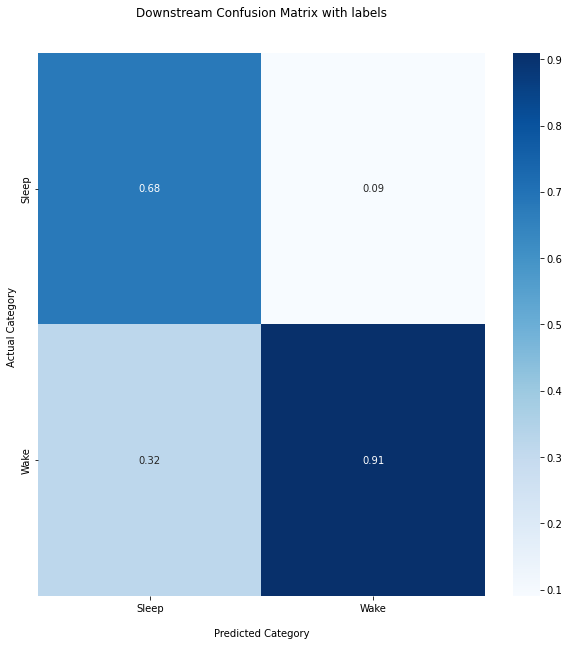

[[42924  2898  6235     0   771]
 [ 2130 30363  2189     0     0]
 [ 2506  3128 33973     0    27]
 [  351    60   330     0   310]
 [ 6728   103  1891     0  4446]]
Precision, Recall and F1 Score for Supine are 0.79, 0.81, 0.8
Precision, Recall and F1 Score for Upright are 0.83, 0.88, 0.85
Precision, Recall and F1 Score for Right are 0.76, 0.86, 0.81
Precision, Recall and F1 Score for Prone are nan, 0.0, nan
Precision, Recall and F1 Score for Left are 0.8, 0.34, 0.48
(5, 5)
Accuracy is nan
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


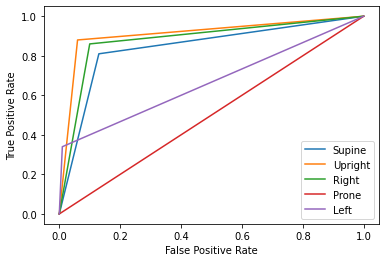

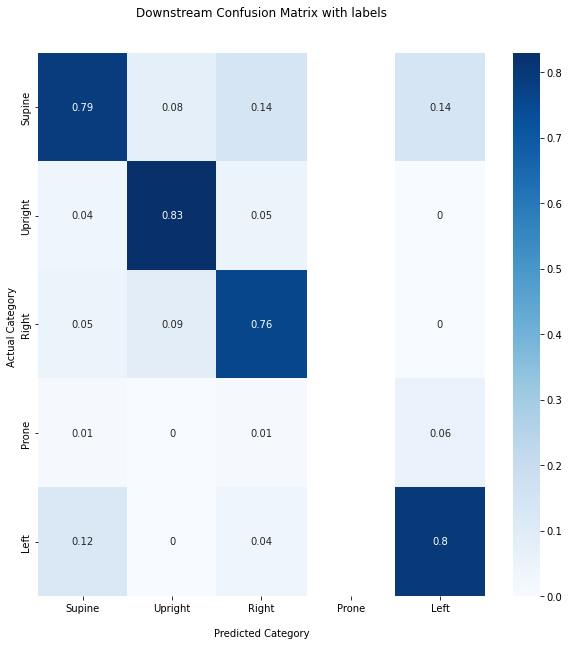

[[  4110  17743      0]
 [  2473 116765      0]
 [     0    272      0]]
Precision, Recall and F1 Score for Slow are 0.62, 0.19, 0.29
Precision, Recall and F1 Score for Normal are 0.87, 0.98, 0.92
Precision, Recall and F1 Score for Fast are nan, 0.0, nan
(3, 3)
Accuracy is nan
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


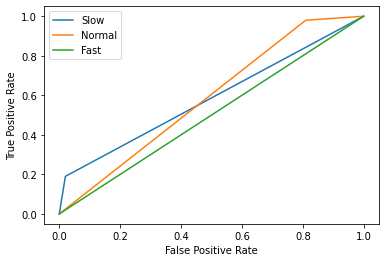

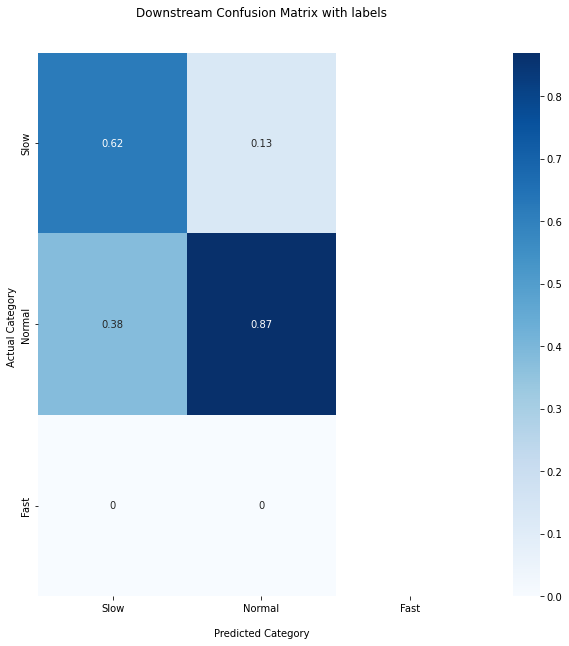

([0.62, 0.87, nan], nan)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(x_train.shape[1],), name='input')

dense_1 = Dense(49, name='dense_1')(input_)
act_1 = Activation('relu', name='act_1')(dense_1)

dense_2 = Dense(24, name='dense_2')(act_1)
act_2 = Activation('relu', name='act_2')(dense_2)


sleep_stage_dense_1 = Dense(10, activation='relu', name='sleep_stage_dense_1')(act_2)
sleep_stage_dense_2 = Dense(5, activation='softmax', name='sleep_stage_dense_2')(sleep_stage_dense_1)

sleep_wake_dense_1 = Dense(10, activation='relu', name='sleep_wake_dense_1')(act_2)
sleep_wake_dense_2 = Dense(2, activation='softmax', name='sleep_wake_dense_2')(sleep_wake_dense_1)

sleep_pos_dense_1 = Dense(10, activation='relu', name='sleep_pos_dense_1')(act_2)
sleep_pos_dense_2 = Dense(5, activation='softmax', name='sleep_pos_dense_2')(sleep_pos_dense_1)

sleep_hr_dense_1 = Dense(10, activation='relu', name='sleep_hr_dense_1')(act_2)
sleep_hr_dense_2 = Dense(3, activation='softmax', name='sleep_hr_dense_2')(sleep_hr_dense_1)

model = tf.keras.models.Model(input_, [sleep_stage_dense_2, sleep_wake_dense_2,sleep_pos_dense_2,sleep_hr_dense_2])
#model.summary()

model.compile(
    loss={
        'sleep_stage_dense_2': 'categorical_crossentropy',
        'sleep_wake_dense_2': 'binary_crossentropy',
        'sleep_pos_dense_2': 'categorical_crossentropy',
        'sleep_hr_dense_2': 'categorical_crossentropy'
    },
    optimizer='RMSprop',
    metrics=['accuracy']
)

_ = model.fit(x_train, [y_train_stage, y_train_wake, y_train_pos, y_train_hr], validation_data=(x_test, [y_test_stage, y_test_wake, y_test_pos, y_test_hr]), 
              epochs=2)

y_preds = model.predict(x_test)

test_labels = np.argmax(y_test_stage, axis=1)
y_pred = np.argmax(y_preds[:][0], axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_wake, axis=1)
y_pred = np.argmax(y_preds[:][1], axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_pos, axis=1)
y_pred = np.argmax(y_preds[:][2], axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

test_labels = np.argmax(y_test_hr, axis=1)
y_pred = np.argmax(y_preds[:][3], axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)


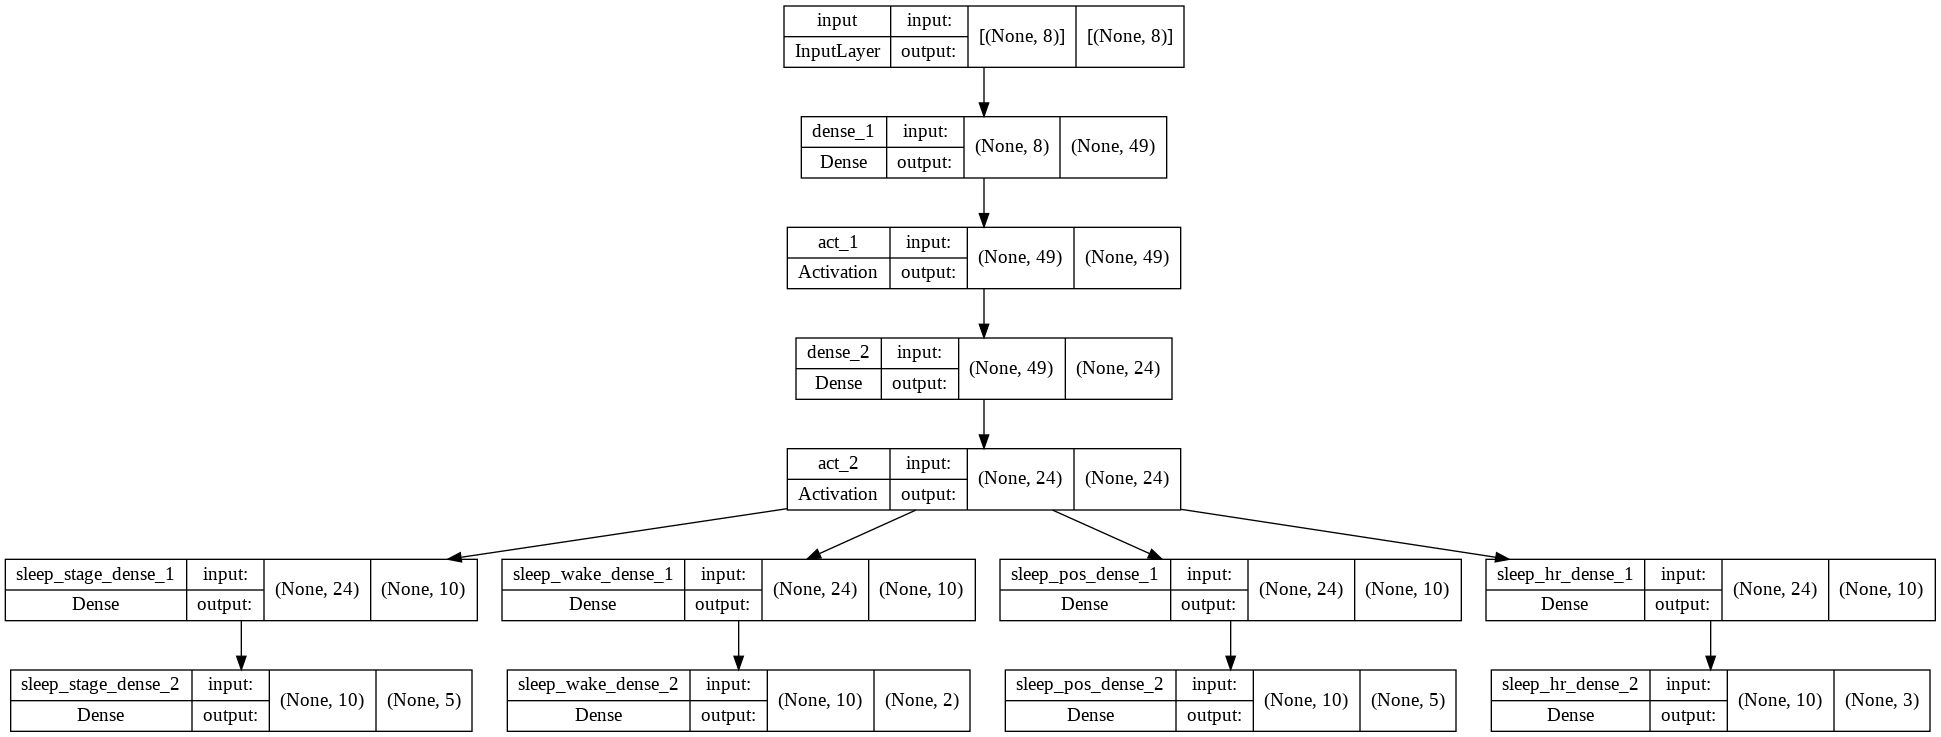

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(x_train.shape[1],), name='input')

dense_1 = Dense(49, name='dense_1')(input_)
act_1 = Activation('relu', name='act_1')(dense_1)

dense_2 = Dense(24, name='dense_2')(act_1)
act_2 = Activation('relu', name='act_2')(dense_2)


sleep_stage_dense_1 = Dense(10, activation='relu', name='sleep_stage_dense_1')(act_2)
sleep_stage_dense_2 = Dense(5, activation='softmax', name='sleep_stage_dense_2')(sleep_stage_dense_1)

sleep_wake_dense_1 = Dense(10, activation='relu', name='sleep_wake_dense_1')(act_2)
sleep_wake_dense_2 = Dense(2, activation='softmax', name='sleep_wake_dense_2')(sleep_wake_dense_1)

sleep_pos_dense_1 = Dense(10, activation='relu', name='sleep_pos_dense_1')(act_2)
sleep_pos_dense_2 = Dense(5, activation='softmax', name='sleep_pos_dense_2')(sleep_pos_dense_1)

sleep_hr_dense_1 = Dense(10, activation='relu', name='sleep_hr_dense_1')(act_2)
sleep_hr_dense_2 = Dense(3, activation='softmax', name='sleep_hr_dense_2')(sleep_hr_dense_1)

model = tf.keras.models.Model(input_, [sleep_stage_dense_2, sleep_wake_dense_2,sleep_pos_dense_2,sleep_hr_dense_2])
#model.summary()

model.compile(
    loss={
        'sleep_stage_dense_2': 'categorical_crossentropy',
        'sleep_wake_dense_2': 'binary_crossentropy',
        'sleep_pos_dense_2': 'categorical_crossentropy',
        'sleep_hr_dense_2': 'categorical_crossentropy'
    },
    optimizer='RMSprop',
    metrics=['accuracy']
)

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)


Sleep stage

In [ ]:
test_labels = np.argmax(y_test_stage, axis=1)

print(np.unique(test_labels, return_counts=True))

(array([0, 1, 2, 3, 4]), array([  4021,  14905,   3097,   4015, 115325]))


Epoch 1/2
23258/23258 [==============================] - 51s 2ms/step - loss: 0.4296 - accuracy: 0.8825 - val_loss: 0.6219 - val_accuracy: 0.8158
Epoch 2/2
23258/23258 [==============================] - 57s 2ms/step - loss: 0.4281 - accuracy: 0.8834 - val_loss: 0.7245 - val_accuracy: 0.8158
[[     0      0      0      0   4021]
 [     0      0      0      0  14905]
 [     0      0      0      0   3097]
 [     0      0      0      0   4015]
 [     0      0      0      0 115325]]
Precision, Recall and F1 Score for N1 are nan, 0.0, nan
Precision, Recall and F1 Score for N2 are nan, 0.0, nan
Precision, Recall and F1 Score for N3 are nan, 0.0, nan
Precision, Recall and F1 Score for REM are nan, 0.0, nan
Precision, Recall and F1 Score for Wake are 0.82, 1.0, 0.9
(5, 5)
Accuracy is nan
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


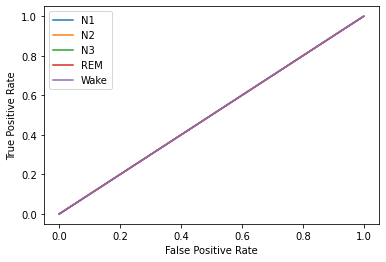

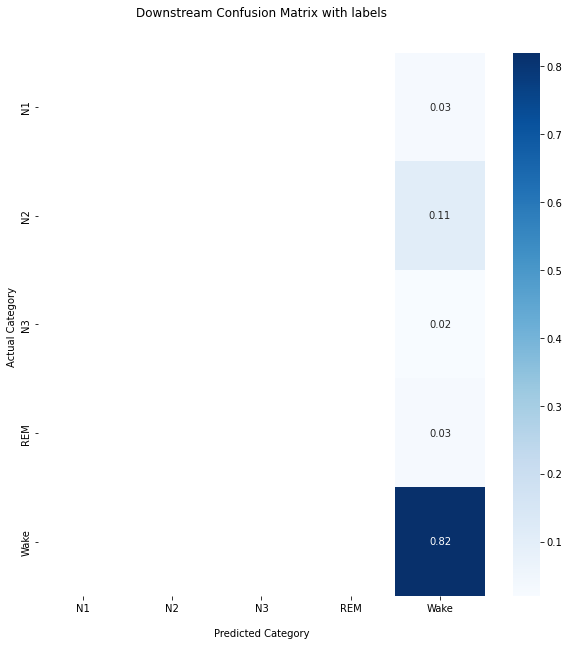

([nan, nan, nan, nan, 0.82], nan)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Dense(49, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
#model.summary()


model.fit(x_train, y_train_stage, validation_data=(x_test, y_test_stage), batch_size=16, epochs=15)

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#history = model.fit(x_train, y_train_stage, validation_data=(x_test, y_test_stage), batch_size=16, epochs=15)

test_labels = np.argmax(y_test_stage, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

Labels = ['N1', 'N2', 'N3', 'REM', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep wake

Epoch 1/15
23258/23258 [==============================] - 29s 1ms/step - loss: 0.3841 - accuracy: 0.8124 - val_loss: 0.4288 - val_accuracy: 0.7597
Epoch 2/15
23258/23258 [==============================] - 27s 1ms/step - loss: 0.3825 - accuracy: 0.8388 - val_loss: 0.5353 - val_accuracy: 0.8198
Epoch 3/15
23258/23258 [==============================] - 27s 1ms/step - loss: 0.3775 - accuracy: 0.8419 - val_loss: 0.5087 - val_accuracy: 0.8269
Epoch 4/15
23258/23258 [==============================] - 32s 1ms/step - loss: 0.3654 - accuracy: 0.8455 - val_loss: 0.4428 - val_accuracy: 0.8110
Epoch 5/15
23258/23258 [==============================] - 32s 1ms/step - loss: 0.3703 - accuracy: 0.8478 - val_loss: 0.4663 - val_accuracy: 0.8331
Epoch 6/15
23258/23258 [==============================] - 32s 1ms/step - loss: 0.3637 - accuracy: 0.8494 - val_loss: 0.4610 - val_accuracy: 0.8328
Epoch 7/15
23258/23258 [==============================] - 31s 1ms/step - loss: 0.3438 - accuracy: 0.8526 - val_loss: 0

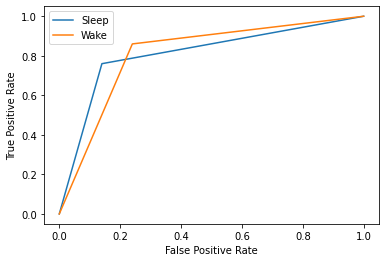

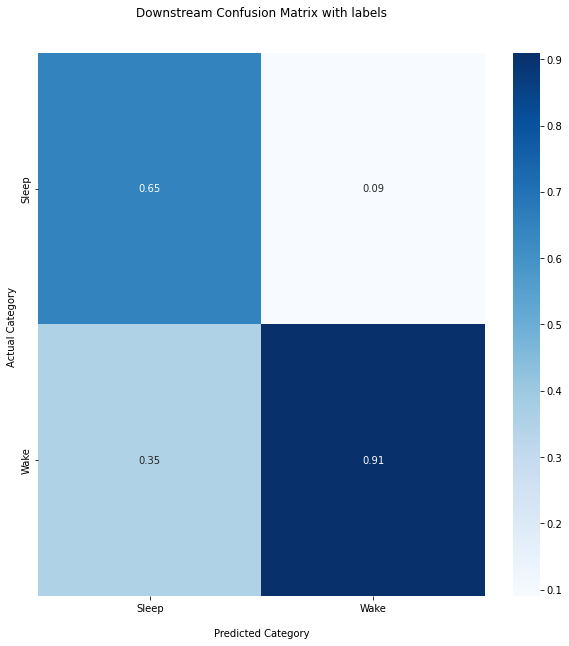

([0.65, 0.91], 0.83)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Dense(49, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_wake, validation_data=(x_test, y_test_wake), batch_size=16, epochs=15)

test_labels = np.argmax(y_test_wake, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

Labels = ['Sleep', 'Wake']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep pos

[[    0 19444     0 33384     0]
 [    0 22092     0 12590     0]
 [    0  5990     0 33644     0]
 [    0    79     0   972     0]
 [    0  2916     0 10252     0]]
Precision, Recall and F1 Score for Supine are nan, 0.0, nan
Precision, Recall and F1 Score for Upright are 0.44, 0.64, 0.52
Precision, Recall and F1 Score for Right are nan, 0.0, nan
Precision, Recall and F1 Score for Prone are 0.01, 0.92, 0.02
Precision, Recall and F1 Score for Left are nan, 0.0, nan
(5, 5)
Accuracy is nan
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


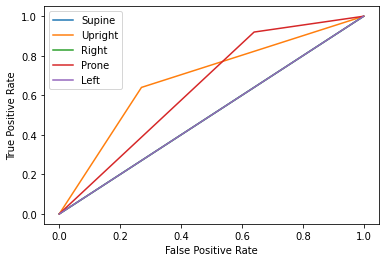

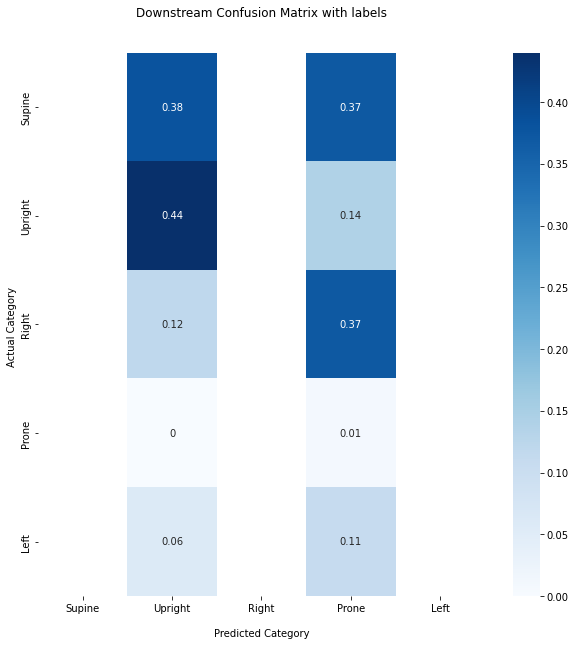

([nan, 0.44, nan, 0.01, nan], nan)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Dense(49, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#history = model.fit(x_train, y_train_pos, validation_data=(x_test, y_test_pos), batch_size=1, epochs=15)

test_labels = np.argmax(y_test_pos, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

Labels = ['Supine', 'Upright', 'Right', 'Prone', 'Left']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Sleep hr

Epoch 1/15
372128/372128 [==============================] - 789s 2ms/step - loss: 0.5081 - accuracy: 0.8623 - val_loss: 0.4868 - val_accuracy: 0.8435
Epoch 2/15
372128/372128 [==============================] - 762s 2ms/step - loss: 0.4102 - accuracy: 0.8633 - val_loss: 0.4850 - val_accuracy: 0.8435
Epoch 3/15
372128/372128 [==============================] - 765s 2ms/step - loss: 0.4104 - accuracy: 0.8633 - val_loss: 0.4904 - val_accuracy: 0.8435
Epoch 4/15
372128/372128 [==============================] - 767s 2ms/step - loss: 0.4102 - accuracy: 0.8633 - val_loss: 0.4916 - val_accuracy: 0.8435
Epoch 5/15
372128/372128 [==============================] - 768s 2ms/step - loss: 0.4104 - accuracy: 0.8633 - val_loss: 0.4923 - val_accuracy: 0.8435
Epoch 6/15
372128/372128 [==============================] - 766s 2ms/step - loss: 0.4105 - accuracy: 0.8633 - val_loss: 0.4889 - val_accuracy: 0.8435
Epoch 7/15
372128/372128 [==============================] - 823s 2ms/step - loss: 0.4105 - accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


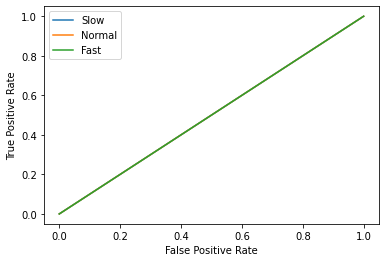

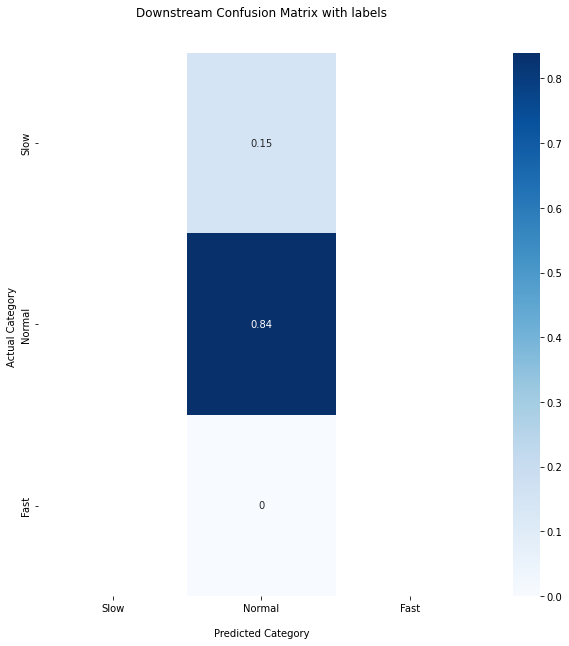

([nan, 0.84, nan], nan)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Dense(49, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train, y_train_hr, validation_data=(x_test, y_test_hr), batch_size=1, epochs=15)

test_labels = np.argmax(y_test_hr, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

Labels = ['Slow', 'Normal', 'Fast']
printConfusionMatrix(test_labels, y_pred, Labels, show=True)

Confusion

In [4]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

#printConfusionMatrix(y_test, y_pred, Labels, show=True)

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)
    
    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Downstream Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)